In [4]:
#https://medium.com/mlearning-ai/univariate-time-series-forecasting-using-rnn-lstm-32702bd5cf4

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import math

import tensorflow as tf

In [6]:
ab_path='../data/SPY-Daily-Y09-Now.csv'

start_date='2016-01-01'
end_date='2022-12-31'

split_by=1  # 1= date 2=percent
if  split_by==1:
 train_ratio=0.8   
else:
 test_date='2021-07-26'   
 
prediction_col='Price'
hops_lookback=22

epochs = 50
batch_size = 32
n_early=0



In [7]:
df=pd.read_csv(f'{ab_path}',parse_dates=['Date/Time'],dayfirst=True)
print(list(df.columns))
df.rename(columns={'Date/Time':'Date'},inplace=True)
df.set_index('Date',inplace=True)
# df.index = pd.to_datetime(df['Date'])
df=df.loc[start_date:end_date,[prediction_col]]
df.sort_index(inplace=True)
print(df.info())


['Ticker', 'Date/Time', 'Price', 'EMA1', 'EMA2', 'EMA3', 'MACD', 'SIGNAL', 'RSI', 'RSI-MA']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1755 entries, 2016-01-04 to 2022-12-20
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   1755 non-null   float64
dtypes: float64(1)
memory usage: 27.4 KB
None


In [8]:
print(df.shape)
if  split_by==1:
 print("Split by train ratio")   
 train_data_length = math.ceil(len(df) * train_ratio)
 print(f"Split the data into train({train_ratio})={train_data_length} and the remaining  is test")   
 df_train=df.iloc[0:train_data_length,:]
 df_test=df.iloc[train_data_length:,:]
else:
 print("Split by test date")    
 df_train=df[:test_date]
 df_test=df[test_date:]



print(df_train.shape, df_train[-3:])
print("===================================")
print(df_test.shape,df_test[-3:])

(1755, 1)
Split by train ratio
Split the data into train(0.8)=1404 and the remaining  is test
(1404, 1)              Price
Date              
2021-07-28  438.83
2021-07-29  440.65
2021-07-30  438.51
(351, 1)              Price
Date              
2022-12-16  383.27
2022-12-19  380.02
2022-12-20  380.54


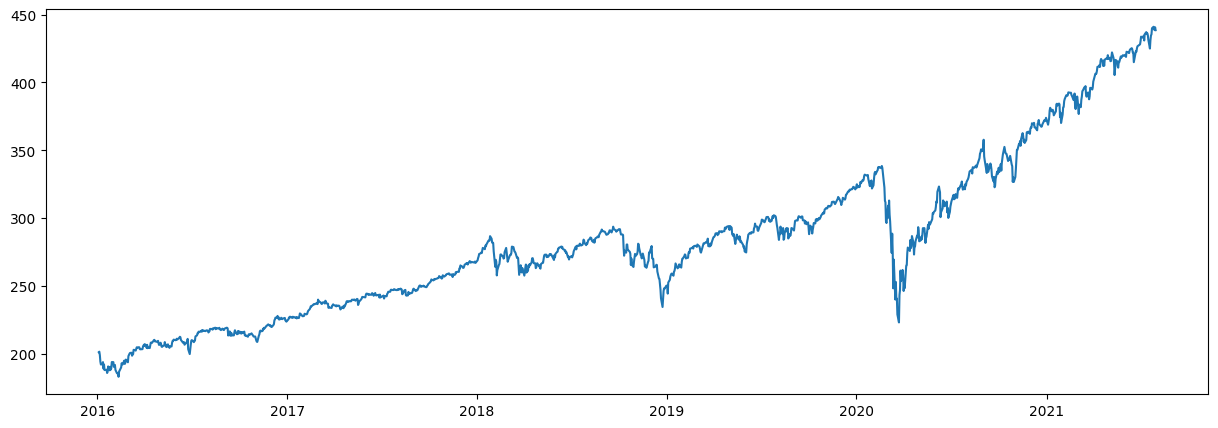

In [9]:
plt.figure(figsize=(15,5))
plt.plot(df_train)
plt.show()



In [10]:
print("Max-Min Scalar only Train")
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler(feature_range=(0, 1))
##scaler = StandardScaler ()
df_scaled_train=scaler.fit_transform(df_train)
print(df_scaled_train.shape)


print(df_scaled_train[:3])
print(df_scaled_train[-3:])

Max-Min Scalar only Train
(1404, 1)
[[0.07034397]
 [0.07166099]
 [0.06182213]]
[[0.99151689]
 [0.99856678]
 [0.99027735]]


In [11]:

total_len=df_scaled_train.shape[0]

X_train=[]
y_train=[]

for i in range(hops_lookback,total_len):
   X_train.append(df_scaled_train[i-hops_lookback:i]) 
   y_train.append(df_scaled_train[i])
    
X_train=np.array(X_train)
y_train=np.array(y_train)

# print(X_train[:3])
# print("=============")
# print(y_train[:3])
# print("#############")
print(X_train.shape)
print(y_train.shape)

# from keras.preprocessing.sequence import TimeseriesGenerator
# generator = TimeseriesGenerator(df_scaled_train, df_scaled_train, length=hops, batch_size=1)
# X,y = generator[3]
# print(f'{prediction_col} the Array: \n{X.flatten()}')
# print(f'Predict this y: \n {y}')

#https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/

(1382, 22, 1)
(1382, 1)


In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.layers import Flatten,Dropout

In [13]:
n_input_lookback=X_train.shape[1]  # n_input=hops it is how far back in time do you want to use for training on time series model.
n_feature=X_train.shape[2]  # univariate is always 1 
print(f'input lookback :{n_input_lookback}')
print(f'in_feature :{n_feature}')

#lstm_neuron_number=50
lstm_neuron_number = n_input_lookback * n_feature  #n_features=1
print(f"{lstm_neuron_number}= {n_input_lookback} x {n_feature} (univariate n_features=1)")



input lookback :22
in_feature :1
22= 22 x 1 (univariate n_features=1)


In [14]:
tf.random.set_seed(7)

model=Sequential()
# return_sequences for adding other hidden layer

model.add(LSTM(units=lstm_neuron_number, return_sequences=False, input_shape=(n_input_lookback,n_feature )))

# model.add(LSTM(units=lstm_neuron_number, return_sequences=True, input_shape=(n_input_lookback,n_feature )))
# model.add(Dropout(0.2))
# model.add(LSTM(units=lstm_neuron_number)) #layer2  additonal
# model.add(Dropout(0.2))


model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 22)                2112      
                                                                 
 dense (Dense)               (None, 1)                 23        
                                                                 
Total params: 2,135
Trainable params: 2,135
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
44/44 - 10s - loss: 0.0026 - 10s/epoch - 227ms/step
Epoch 2/50
44/44 - 1s - loss: 0.0077 - 824ms/epoch - 19ms/step
Epoch 3/50
44/44 - 1s - loss: 7.0326e-04 - 823ms/epoch - 19ms/step
Epoch 4/50
44/44 - 1s - loss: 6.3569e-04 - 829ms/epoch - 19ms/step
Epoch 5/50
44/44 - 1s - loss: 6.1630e-04 - 895ms/epoch - 20ms/step
Epoch 6/50
44/44 - 1s - loss: 6.0084e-04 - 848ms/epoch - 19ms/step
Epoch 7/50
44/44 - 1s - loss: 5.8872e-04 - 832ms/epoch - 19ms/step
Epoch 8/50
44/44 - 1s - loss: 5.7652e-04 - 725ms/epoch - 16ms/step
Epoch 9/50
44/44 - 1s - loss: 5.6467e-04 - 697ms/epoch - 16ms/step
Epoch 10/50
44/44 - 1s - loss: 5.5300e-04 - 704ms/epoch - 16ms/step
Epoch 11/50
44/44 - 1s - loss: 5.4136e-04 - 668ms/epoch - 15ms/step
Epoch 12/50
44/44 - 1s - loss: 5.2970e-04 - 766ms/epoch - 17ms/step
Epoch 13/50
44/44 - 1s - loss: 5.1807e-04 - 752ms/epoch - 17ms/step
Epoch 14/50
44/44 - 1s - loss: 5.0659e-04 - 711ms/epoch - 16ms/step
Epoch 15/50
44/44 - 1s - loss: 4.9536e-04 - 722ms/epoch - 16ms/st

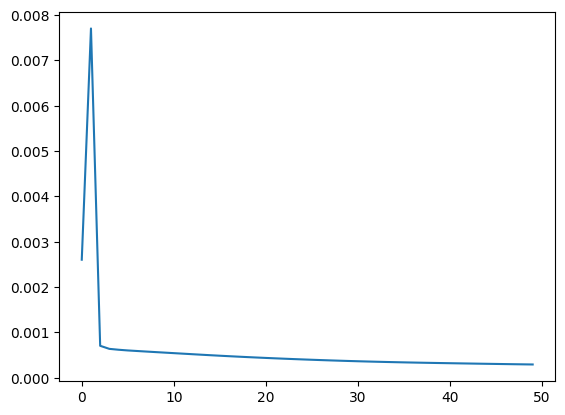

In [15]:
if n_early>0:
 callback = EarlyStopping(monitor='loss', patience=n_early)
 model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size, shuffle=False,verbose=2,callbacks=[callback])
else:
 model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size, shuffle=False,verbose=2)

# plot history
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

# Get Test Data(Unseen) by include {n_input_lookback} to predict

In [16]:
df_new=df.values
# test_arr will get start with the last n look back to predict
test_arr=df_new[len(df_new)-len(df_test)-n_input_lookback:]
print(f"Get Test Data {len(df_test)} + {n_input_lookback} to predict = {test_arr.shape}")
print(test_arr.shape)
test_scaled_arr=scaler.fit_transform(test_arr)
print(test_scaled_arr.shape)
test_scaled_arr[:5]

Get Test Data 351 + 22 to predict = (373, 1)
(373, 1)
(373, 1)


array([[0.59017747],
       [0.60973999],
       [0.63689641],
       [0.63037557],
       [0.64300454]])

In [17]:
#No.row = len(test_arr)-n_hop_lookback  , we will start triaing at the first rows since n_hop
X_test=[]
for i in range(hops_lookback,test_scaled_arr.shape[0]):
   X_test.append(test_scaled_arr[i-hops_lookback:i]) 

X_test=np.array(X_test)
print(X_test.shape)
# print(X_test[:2])

(351, 22, 1)


In [18]:
y_test_scaled_pred=model.predict(X_test)
print("Before Invert :",y_test_scaled_pred.shape)
y_test_pred=scaler.inverse_transform(y_test_scaled_pred)
print("After Invert :" ,y_test_pred.shape)
y_test_pred[:5]

11/11 [==============================] - 1s 7ms/step
Before Invert : (351, 1)
After Invert : (351, 1)


array([[438.70807],
       [438.4601 ],
       [439.07364],
       [438.94858],
       [439.55014]], dtype=float32)

In [19]:
pred_col_result=f'Predict-{prediction_col}'
test_pred_df=pd.DataFrame(y_test_pred,columns=[pred_col_result])
print(test_pred_df.info())
test_pred_df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Predict-Price  351 non-null    float32
dtypes: float32(1)
memory usage: 1.5 KB
None


,Predict-Price
346,396.625763
347,397.072998
348,395.137451
349,391.848877
350,388.187714


In [20]:
print(df_test.info())
df_test=df_test.reset_index()
df_test.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 351 entries, 2021-08-02 to 2022-12-20
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   351 non-null    float64
dtypes: float64(1)
memory usage: 5.5 KB
None


,Date,Price
346,2022-12-14,399.40
347,2022-12-15,389.63
348,2022-12-16,383.27
349,2022-12-19,380.02
350,2022-12-20,380.54


In [21]:
dfABC=pd.concat([df_test,test_pred_df],axis=1)
dfABC=dfABC.set_index('Date')
dfABC.tail()

,Price,Predict-Price
Date,,
2022-12-14,399.40,396.625763
2022-12-15,389.63,397.072998
2022-12-16,383.27,395.137451
2022-12-19,380.02,391.848877
2022-12-20,380.54,388.187714


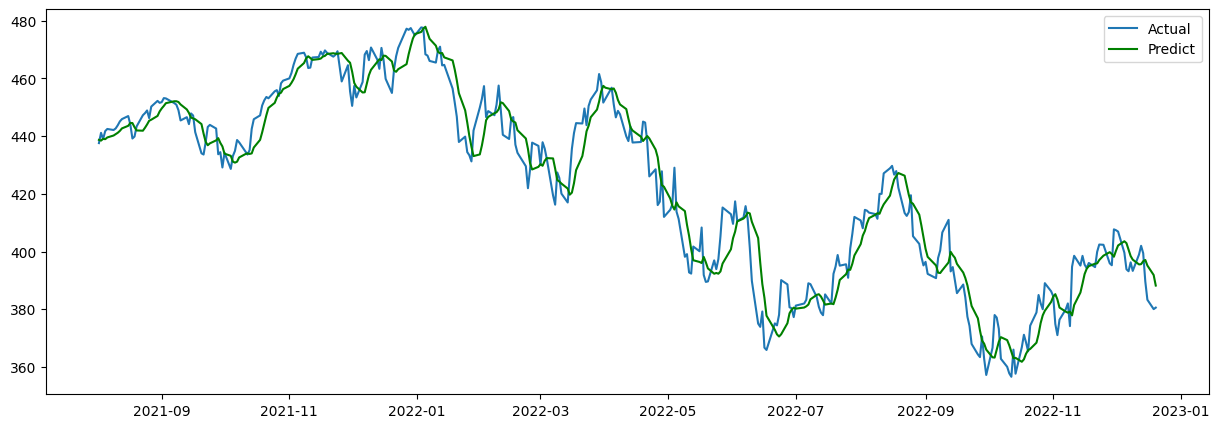

In [22]:
plt.figure(figsize=(15,5))
plt.plot(dfABC[prediction_col],label='Actual')
plt.plot(dfABC[pred_col_result],color='green',label='Predict')
plt.legend()
plt.show()

In [23]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
rmse = np.sqrt(mean_squared_error(dfABC[prediction_col], dfABC[pred_col_result]))
print('Root Mean Square Error(RMSE): %.3f' % rmse)
# Mean Absolute Error (MAE)
mae=mean_absolute_error(dfABC[prediction_col], dfABC[pred_col_result])
print('Mean Absolute Error (MAE): ' + str(np.round(mae, 2)))

Root Mean Square Error(RMSE): 7.719
Mean Absolute Error (MAE): 6.16
